In [ ]:
!python -m pip install cityscapesscripts


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 473.6/473.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.8 MB/s eta 0:00:00
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26306 sha256=debc85fe900163c13b1bac7923785d40ac918f373dddb24cdbdcff1452903706
  Stored in directory: /root/.cache/pip/wheels/7c/d0/9e/1f26ebb66d9e1732e4098bc5a6c2d91f6c9a529838f0284890
Successfully built typing


In [ ]:
from cityscapesscripts.download import downloader

#registered at cityscapes-dataset.com

session = downloader.login()
downloader.get_available_packages(session=session)

#data choice
print('downloading gtfine and leftImg8bit packages ... \n')

package_list = {'leftImg8bit_trainvaltest.zip','vehicle_trainvaltest.zip'}
downloader.download_packages(session=session, package_names=package_list, destination_path=r'/content/')

Cityscapes username or email address: Jaideep
Cityscapes password: ··········
Store credentials unencrypted in '/root/.local/share/cityscapesscripts/credentials.json' [y/N]: y
downloading gtfine and leftImg8bit packages ... 



Download progress:  98%|█████████▊| 10.8G/11.0G [03:44<00:04, 51.5MB/s]


Download progress:  91%|█████████ | 1.82M/2.00M [00:00<00:00, 17.1MB/s]


In [ ]:
!unzip /content/leftImg8bit_trainvaltest.zip -d /content/leftImg

Streaming output truncated to the last 5000 lines.
 extracting: /content/leftImg/leftImg8bit/train/jena/jena_000074_000019_leftImg8bit.png  
 extracting: /content/leftImg/leftImg8bit/train/jena/jena_000040_000019_leftImg8bit.png  
 extracting: /content/leftImg/leftImg8bit/train/jena/jena_000020_000019_leftImg8bit.png  
 extracting: /content/leftImg/leftImg8bit/train/jena/jena_000030_000019_leftImg8bit.png  
 extracting: /content/leftImg/leftImg8bit/train/jena/jena_000005_000019_leftImg8bit.png  
 extracting: /content/leftImg/leftImg8bit/train/jena/jena_000059_000019_leftImg8bit.png  
 extracting: /content/leftImg/leftImg8bit/train/jena/jena_000100_000019_leftImg8bit.png  
 extracting: /content/leftImg/leftImg8bit/train/jena/jena_000034_000019_leftImg8bit.png  
 extracting: /content/leftImg/leftImg8bit/train/jena/jena_000089_000019_leftImg8bit.png  
 extracting: /content/leftImg/leftImg8bit/train/jena/jena_000104_000019_leftImg8bit.png  
 extracting: /content/leftImg/leftImg8bit/train/j

In [ ]:
!unzip /content/vehicle_trainvaltest.zip -d /content

Streaming output truncated to the last 5000 lines.
  inflating: /content/vehicle/train/ulm/ulm_000079_000019_vehicle.json  
  inflating: /content/vehicle/train/ulm/ulm_000012_000019_vehicle.json  
  inflating: /content/vehicle/train/ulm/ulm_000060_000019_vehicle.json  
  inflating: /content/vehicle/train/ulm/ulm_000049_000019_vehicle.json  
  inflating: /content/vehicle/train/ulm/ulm_000081_000019_vehicle.json  
  inflating: /content/vehicle/train/ulm/ulm_000006_000019_vehicle.json  
  inflating: /content/vehicle/train/ulm/ulm_000044_000019_vehicle.json  
  inflating: /content/vehicle/train/ulm/ulm_000074_000019_vehicle.json  
  inflating: /content/vehicle/train/ulm/ulm_000036_000019_vehicle.json  
  inflating: /content/vehicle/train/ulm/ulm_000055_000019_vehicle.json  
  inflating: /content/vehicle/train/ulm/ulm_000067_000019_vehicle.json  
  inflating: /content/vehicle/train/ulm/ulm_000086_000019_vehicle.json  
  inflating: /content/vehicle/train/ulm/ulm_000005_000019_vehicle.json  


In [ ]:
from cityscapesscripts.download import downloader
import torch
from torch.utils.data import Dataset, DataLoader  # Import Dataset and DataLoader
from PIL import Image
import json
import glob
import os
import numpy as np
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, split='train'):
        self.root_dir = root_dir
        self.split = split
        self.img_dir = os.path.join(root_dir, f'/content/leftImg/leftImg8bit/{split}')
        self.mask_dir = os.path.join(root_dir, f'/content/gtFine/gtFine/{split}')
        self.json_dir = os.path.join(root_dir, f'/content/vehicle/{split}')
        self.img_list = glob.glob(f'{self.img_dir}/*/*_leftImg8bit.png')

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_path = self.img_list[idx]
        city, filename = os.path.split(img_path)
        city = os.path.basename(city)
        base_filename = filename.split('_leftImg8bit.png')[0]
        json_path = os.path.join(self.json_dir, city, f'{base_filename}_vehicle.json')

        # Load image
        img = Image.open(img_path).convert('RGB')

        # Resize image to 300x150 while maintaining aspect ratio
        img = img.resize((224, 224), Image.LANCZOS)  # Note: Updated to use LANCZOS as per the deprecation warning

        # Load json and extract temperature value
        with open(json_path, 'r') as f:
            data = json.load(f)
        temperature = data['outsideTemperature']  # Assuming temperature is a key in your JSON

        # Convert to PyTorch tensors
        img = torch.tensor(np.array(img), dtype=torch.float32).permute(2, 0, 1) / 255.0  # Normalize to [0, 1]
        temperature = torch.tensor(temperature, dtype=torch.float32)

        return img, temperature  # Return only image and temperature

# Usage:
root_dir = 'Data'
train_dataset = CustomDataset(root_dir, split='train')
val_dataset = CustomDataset(root_dir, split='val')
test_dataset=CustomDataset(root_dir, split='test')
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



In [ ]:
total_images = len(train_loader.dataset)
print(f'Total number of images: {total_images}')

Total number of images: 2975


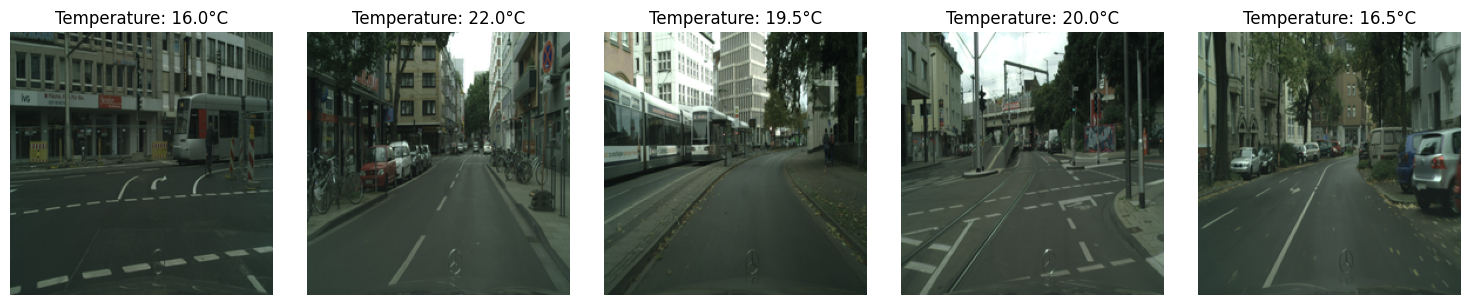

In [ ]:
def display_random_samples(train_loader):
    # Get a random batch of data
    img_batch, temp_batch = next(iter(train_loader))  # Updated to match the updated data loader

    # Randomly select 5 indices from the batch
    random_indices = np.random.choice(img_batch.shape[0], 5, replace=False)

    fig, axs = plt.subplots(1, 5, figsize=(15, 3))  # Adjusted subplot layout to 1 row and 5 columns

    for i, idx in enumerate(random_indices):
        # Get the corresponding image and temperature
        img = img_batch[idx].permute(1, 2, 0).numpy()
        temperature = temp_batch[idx].item()

        # Set the temperature as the title for each column
        axs[i].set_title(f'Temperature: {temperature}°C')

        # Display the RGB image
        axs[i].imshow(img)
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

# Usage:
display_random_samples(train_loader)

In [ ]:
# from transformers import SwinForImageClassification
# from torch import nn
# import torch.optim as optim

# # Load pre-trained Swin Transformer model
# model = SwinForImageClassification.from_pretrained('microsoft/swin-base-patch4-window7-224')

# # Modify the pre-trained model for regression
# model.num_labels = 1
# model.classifier = nn.Linear(model.config.hidden_size, 1)

# # Replace the original classifier with a regression layer
# model.classifier = nn.Sequential(
#     nn.Dropout(p=0.5),
#     nn.Linear(in_features=model.config.hidden_size, out_features=1)
# )

# # Define loss function and optimizer
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-4)

# # Train and validate the model
# # ... (training loop goes here)



In [ ]:
def unfreeze_model_layers(model, last_n_stages):
    # Freeze all parameters first
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze the last N stages of the encoder
    for stage in model.swin.encoder.layers[-last_n_stages:]:
        print(stage)
        for param in stage.parameters():
            param.requires_grad = True

    # Ensure the classifier/regressor layer is unfrozen
    for param in model.classifier.parameters():
        param.requires_grad = True

# Example usage: Unfreeze the last 2 stages of the encoder and the classifier



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels, atrous_rates):
        super(ASPP, self).__init__()
        modules = []
        # 1x1 conv
        modules.append(
            nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        )

        # Atrous convolutions
        for rate in atrous_rates:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, 3, padding=rate, dilation=rate, bias=False),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(inplace=True)
                )
            )

        # Image pooling
        self.global_avg_pool = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

        self.convs = nn.ModuleList(modules)

        # Project all concatenated features to `out_channels`
        self.project = nn.Sequential(
            nn.Conv2d(len(modules) * out_channels + out_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5)
        )

    def forward(self, x):
        res = []
        for conv in self.convs:
            res.append(conv(x))
        res.append(F.interpolate(self.global_avg_pool(x), size=x.shape[2:], mode='bilinear', align_corners=False))
        res = torch.cat(res, dim=1)
        return self.project(res)

In [ ]:
from transformers import SwinModel, AutoFeatureExtractor
from torch import nn
import torch

class SwinTransformerWithASPP(nn.Module):
    def __init__(self, pretrained_model_name, in_channels, out_channels, atrous_rates):
        super(SwinTransformerWithASPP, self).__init__()
        # Load the pre-trained Swin Transformer model specifically for feature extraction
        self.swin = SwinModel.from_pretrained(pretrained_model_name,output_hidden_states=True)
        print(self.swin)
        # ASPP Module initialization
        self.aspp = ASPP(in_channels, out_channels, atrous_rates)

        # Regressor adjusted based on the ASPP output
        self.regressor = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(out_channels, 1)  # Adjust based on ASPP output and any pooling/flattening
        )

    def forward(self, inputs):
        # Extract hidden states from the Swin Transformer
        outputs = self.swin(inputs)
        hidden_states = outputs.hidden_states  # Tuple of hidden states at each layer
        # print(hidden_states[-1].shape)
        # print(hidden_states[-2].shape)
        # print(hidden_states[-3].shape)

        features = hidden_states[-1]
        features = features.permute(0, 2, 1).view(features.shape[0], 1024, 7, 7)


        # Process features through ASPP
        aspp_features = self.aspp(features)

        # Pooling and flattening for regression
        # Assuming a global average pooling to reduce spatial dimensions to 1x1
        pooled_features = torch.flatten(torch.mean(aspp_features, dim=[2, 3]), start_dim=1)

        # Temperature prediction
        temperature = self.regressor(pooled_features)

        return temperature

# Note: When initializing and using this model, ensure you preprocess your inputs
# using the appropriate feature extractor for Swin Transformers:
# feature_extractor = AutoFeatureExtractor.from_pretrained(pretrained_model_name)
# inputs = feature_extractor(images=your_images, return_tensors="pt")


In [ ]:
model = SwinTransformerWithASPP('microsoft/swin-base-patch4-window7-224', in_channels=1024, out_channels=256, atrous_rates=[6, 12, 18])
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/352M [00:00<?, ?B/s]

SwinModel(
  (embeddings): SwinEmbeddings(
    (patch_embeddings): SwinPatchEmbeddings(
      (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    )
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): SwinEncoder(
    (layers): ModuleList(
      (0): SwinStage(
        (blocks): ModuleList(
          (0-1): 2 x SwinLayer(
            (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (attention): SwinAttention(
              (self): SwinSelfAttention(
                (query): Linear(in_features=128, out_features=128, bias=True)
                (key): Linear(in_features=128, out_features=128, bias=True)
                (value): Linear(in_features=128, out_features=128, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): SwinSelfOutput(
                (dense): Linear(in_features=128, out_features=128, bias=T

In [ ]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm  # for progress bars
from torch import nn, optim

# Assuming 'train_loader' and 'val_loader' are defined

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Send model to device
model.to(device)

# Loss function
criterion = nn.MSELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Number of epochs
num_epochs = 20

# Track the best validation loss
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, temperatures in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}, Training"):
        images, temperatures = images.to(device), temperatures.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images).squeeze(-1)   # Make sure this matches your model output
        loss = criterion(outputs, temperatures)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Step the learning rate scheduler
    # scheduler.step()

    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    print(f'Train loss: {epoch_loss:.4f}')

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for images, temperatures in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs}, Validation"):
            images, temperatures = images.to(device), temperatures.to(device)
            outputs = model(images).squeeze(-1)  # Make sure this matches your model output
            loss = criterion(outputs, temperatures)
            val_running_loss += loss.item()

    val_epoch_loss = val_running_loss / len(val_loader)
    print(f'Validation loss: {val_epoch_loss:.4f}')

    # Save the model if validation loss has decreased
    if val_epoch_loss < best_val_loss:
        print(f'Validation loss decreased ({best_val_loss:.4f} --> {val_epoch_loss:.4f}). Saving model...')
        best_val_loss = val_epoch_loss

        torch.save(model.state_dict(), 'best_model.pth')
        if epoch==60:
          torch.save(model.state_dict(), '/content/drive/MyDrive/best_model.pth')



In [ ]:
# !pip install numba

# from numba import cuda
# device = cuda.get_current_device()
# device.reset()

In [ ]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm  # for progress bars
from torch import nn, optim

# Assuming 'model', 'train_loader', 'val_loader', device, criterion, optimizer, and scheduler are defined

# Load the best model
model.load_state_dict(torch.load('/content/best_model.pth'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Move model to the appropriate device
model.to(device)
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)
# Define additional number of epochs to train
additional_epochs = 10

# Make sure to define or re-define the best validation loss if you want to keep track of improvements
# You might load this value from the checkpoint as well, if you saved it
best_val_loss = float('inf')  # Or load this from the checkpoint if you saved it

for epoch in range(additional_epochs):
    model.train()
    running_loss = 0.0
    for images, temperatures in tqdm(train_loader, desc=f"Additional Epoch {epoch+1}/{additional_epochs}, Training"):
        images, temperatures = images.to(device), temperatures.to(device)

        optimizer.zero_grad()

        outputs = model(images).squeeze(-1)  # Adjust according to your model's output
        loss = criterion(outputs, temperatures)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Uncomment the next line if you're using a scheduler and wish to step it every epoch
    # scheduler.step()

    epoch_loss = running_loss / len(train_loader)
    print(f'Train loss: {epoch_loss:.4f}')

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for images, temperatures in tqdm(val_loader, desc=f"Additional Epoch {epoch+1}/{additional_epochs}, Validation"):
            images, temperatures = images.to(device), temperatures.to(device)
            outputs = model(images).squeeze(-1)  # Adjust according to your model's output
            loss = criterion(outputs, temperatures)
            val_running_loss += loss.item()

    val_epoch_loss = val_running_loss / len(val_loader)
    print(f'Validation loss: {val_epoch_loss:.4f}')

    # Check and save the model if validation loss has improved
    if val_epoch_loss < best_val_loss:
        print(f'Validation loss decreased ({best_val_loss:.4f} --> {val_epoch_loss:.4f}). Saving model...')
        best_val_loss = val_epoch_loss
        torch.save(model.state_dict(), 'best_model.pth')


In [ ]:
from transformers import SwinForImageClassification
from torch import nn
import torch.optim as optim

# Load pre-trained Swin Transformer model
model = SwinForImageClassification.from_pretrained('microsoft/swin-base-patch4-window7-224')

# Modify the pre-trained model for regression
model.num_labels = 1
model.classifier = nn.Linear(model.config.hidden_size, 1)

# Replace the original classifier with a regression layer
model.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(in_features=model.config.hidden_size, out_features=1)
)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
unfreeze_model_layers(model,2)
# Train and validate the model
# ... (training loop goes here)



SwinStage(
  (blocks): ModuleList(
    (0-17): 18 x SwinLayer(
      (layernorm_before): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attention): SwinAttention(
        (self): SwinSelfAttention(
          (query): Linear(in_features=512, out_features=512, bias=True)
          (key): Linear(in_features=512, out_features=512, bias=True)
          (value): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (output): SwinSelfOutput(
          (dense): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
      (drop_path): SwinDropPath(p=0.1)
      (layernorm_after): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (intermediate): SwinIntermediate(
        (dense): Linear(in_features=512, out_features=2048, bias=True)
        (intermediate_act_fn): GELUActivation()
      )
      (output): SwinOutput(
        (dense): Linear(i

In [ ]:
torch.save(model.state_dict(), "best.pth")

In [ ]:
model.load_state_dict(torch.load("/content/best_model.pth", map_location=torch.device('cpu')))


<All keys matched successfully>

In [ ]:
# model = torch.load("/content/best_model.pth", map_location=torch.device('cpu'))


In [ ]:
import torch
from torch.utils.data import DataLoader
import numpy as np

# Assuming val_loader is defined and your model is trained and set to evaluation mode with model.eval()

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# No gradient computation needed
with torch.no_grad():
    squared_errors = []
    for images, true_temperatures in test_loader:
        images, true_temperatures = images.to(device), true_temperatures.to(device)

        # Forward pass to get the predicted temperatures
        predicted_temperatures = model(images).logits.squeeze(-1)  # Ensure this matches your model's output

        # Calculate squared errors
        errors = (predicted_temperatures - true_temperatures) ** 2
        squared_errors.extend(errors.cpu().numpy())  # Move errors to CPU and convert to numpy

    # Calculate RMSE
    rmse = np.sqrt(np.mean(squared_errors))
    print(f'Test RMSE: {rmse:.2f} °C')


Test RMSE: 4.83 °C


In [ ]:
import torch
from torch.utils.data import DataLoader
import numpy as np

# Assuming val_loader is defined and your model is trained and set to evaluation mode with model.eval()

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# No gradient computation needed
with torch.no_grad():
    squared_errors = []
    for images, true_temperatures in val_loader:
        images, true_temperatures = images.to(device), true_temperatures.to(device)

        # Forward pass to get the predicted temperatures
        predicted_temperatures = model(images).logits.squeeze(-1)  # Ensure this matches your model's output

        # Calculate squared errors
        errors = (predicted_temperatures - true_temperatures) ** 2
        squared_errors.extend(errors.cpu().numpy())  # Move errors to CPU and convert to numpy

    # Calculate RMSE
    rmse = np.sqrt(np.mean(squared_errors))
    print(f'Validation RMSE: {rmse:.2f} °C')


Validation RMSE: 4.58 °C


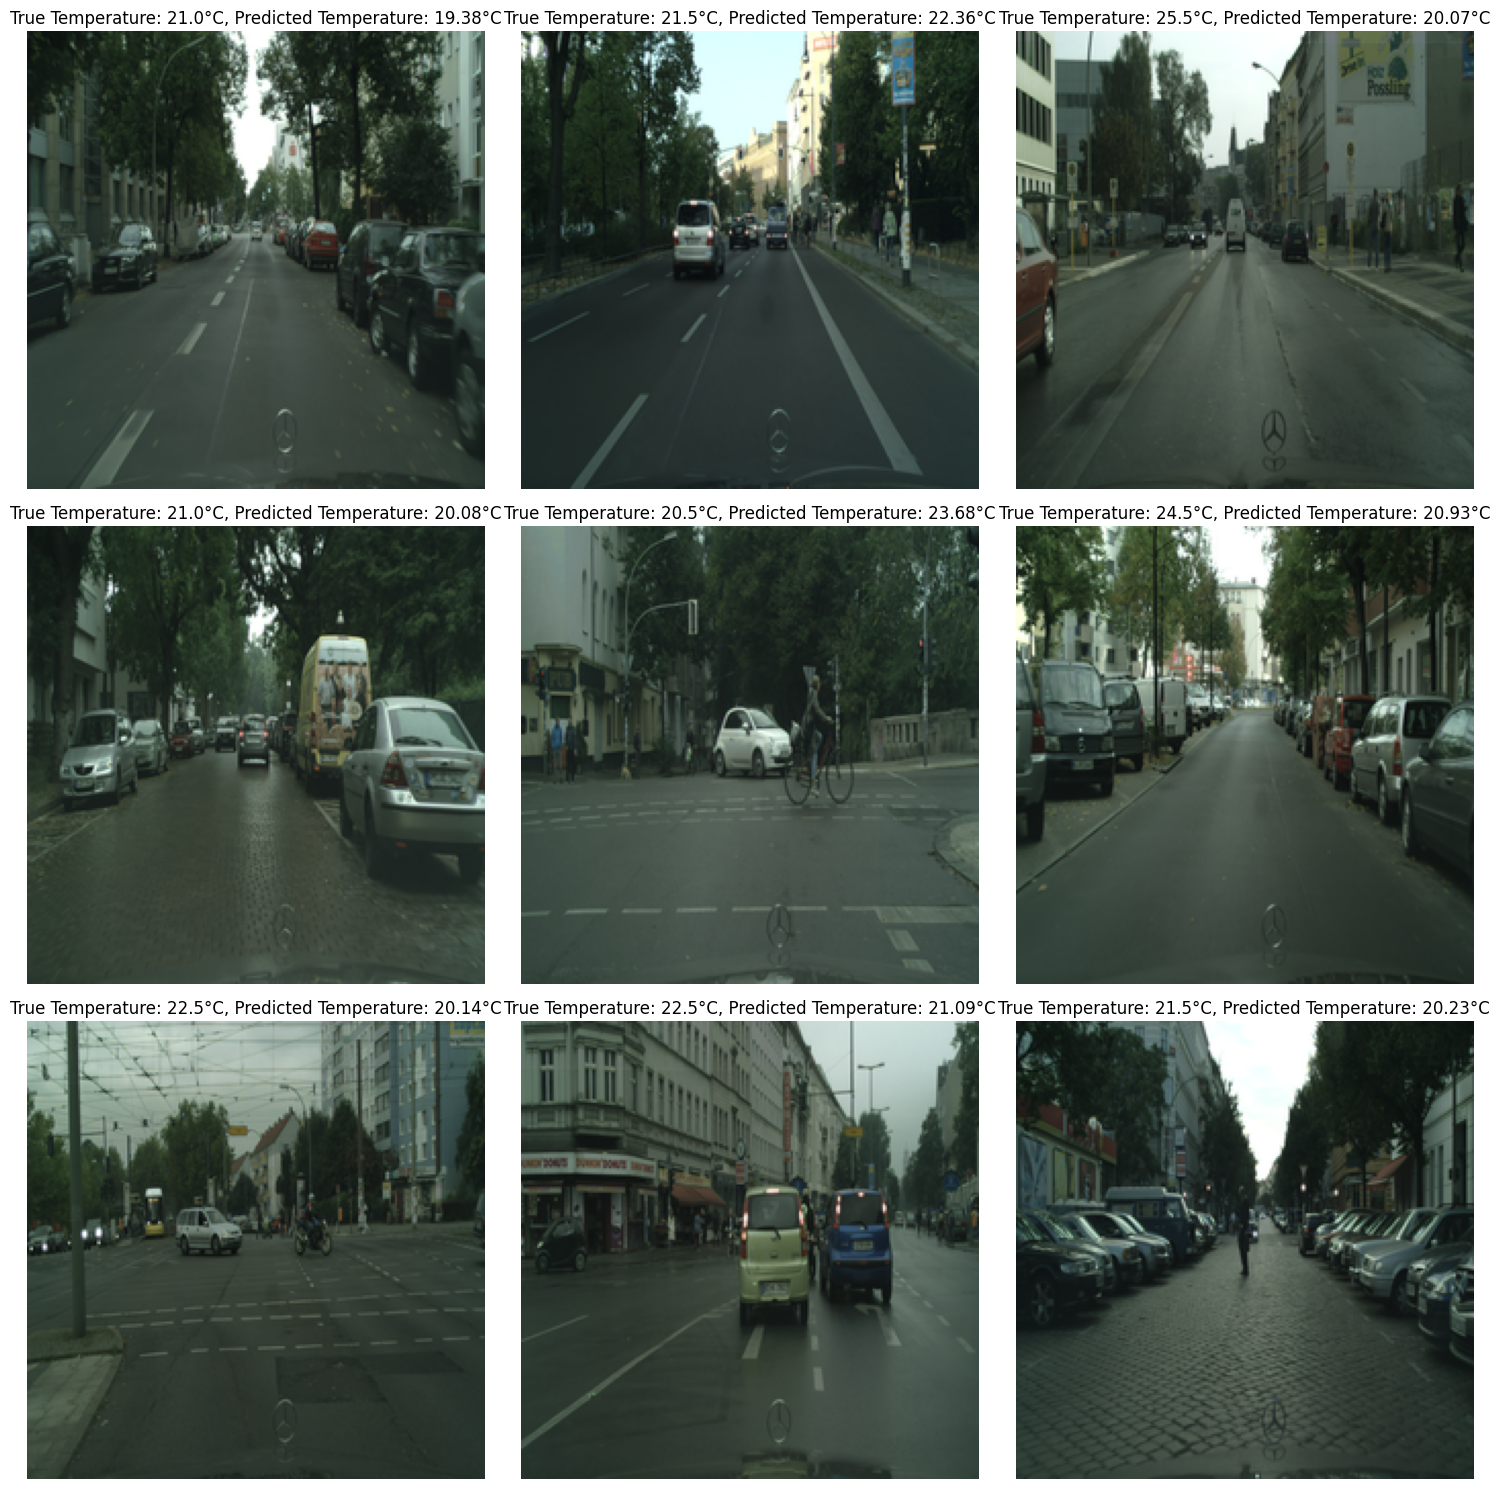

In [ ]:
def visualize_predictions(model, val_loader):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # Get a batch of data from the validation loader
        inputs, regression_target = next(iter(val_loader))
        # If you have a GPU
        if torch.cuda.is_available():
            inputs = inputs.cuda()
        # Get the model's predictions
        predictions = model(inputs)
        # If you have a GPU
        if torch.cuda.is_available():
            predictions = predictions.cpu()
            inputs = inputs.cpu()  # Move inputs to CPU
            regression_target = regression_target.cpu()  # Move regression_target to CPU

        # Select 9 random indices
        random_indices = np.random.choice(inputs.shape[0], 9, replace=False)

        # Create a 3x3 grid of subplots
        fig, axs = plt.subplots(3, 3, figsize=(15, 15))

        for i, idx in enumerate(random_indices):
            # Get the corresponding inputs, targets, and predictions
            img = inputs[idx].permute(1, 2, 0).numpy()
            true_temp = regression_target[idx].item()
            pred_temp  = predictions.logits[idx].item()


            # Determine the position of the subplot in the grid
            row = i // 3
            col = i % 3

            # Display the image along with the true and predicted temperatures
            axs[row, col].imshow(img)
            axs[row, col].set_title(f'True Temperature: {true_temp}°C, Predicted Temperature: {pred_temp:.2f}°C')
            axs[row, col].axis('off')

        plt.tight_layout()  # Adjusts the spacing between subplots for better readability
        plt.show()

# Usage:
visualize_predictions(model, test_loader)